In [1]:
import pandas as pd
import numpy as np
from math import log, sqrt, exp
from scipy.stats import norm
import matplotlib.pyplot as plt

c:\Users\anjal\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Q1

In [2]:
S0 = 200.47                    
K  = 200.0                     
r  = 0.0391                    
q  = 0.0                       
call_mkt = 23.50
put_mkt  = 21.00

# Maturity: 2026-01-16 from 2025-10-31
T = (pd.Timestamp('2026-01-16') - pd.Timestamp('2025-10-31')).days / 365.0
M = 100  # contract multiplier

In [3]:
def bs_price_vega(S, K, r, q, T, sigma, is_call=True, return_vega=True):
    d1 = (log(S/K) + (r-q+(0.5*(sigma**2)))*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    
    if is_call:
        price = S * exp(-q * T) * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    else:
        price = K * exp(-r * T) * norm.cdf(-d2) - S * exp(-q * T) * norm.cdf(-d1)

    if return_vega:
        vega = S*exp(-q*T)*norm.pdf(d1)*sqrt(T)
        return price, vega
    
    return price

In [4]:
call_price, call_vega = bs_price_vega(S=S0, K=K, r=r, q=q, T=T, sigma=0.4)
print(f"Call price: ${call_price:.2f} and call vega: {call_vega:.2f}")

put_price, put_vega = bs_price_vega(S=S0, K=K, r=r, q=q, T=T, sigma=0.4, is_call=False)
print(f"Put price: ${put_price:.2f} and put vega: {put_vega:.2f}")

Call price: $15.68 and call vega: 36.32
Put price: $13.56 and put vega: 36.32


In [ ]:
def implied_vol_newton_raphson(mkt_price, S, K, r, q, T, is_call=True, sigma0=0.3, tol=1e-8, max_iter=100):

    sigma = sigma0
    for _ in range(max_iter):
        price, vega = bs_price_vega(S, K, r, q, T, sigma, is_call=is_call)
        diff = price - mkt_price
        if abs(diff) < tol: # difference in BS call/put price and market call/put price should not exceed the tolerance
            break
        sigma -= diff / vega
        
    return max(sigma, 0.0)

In [6]:
iv_call = implied_vol_newton_raphson(call_mkt, S0, K, r, q, T)
iv_put  = implied_vol_newton_raphson(put_mkt , S0, K, r, q, T, is_call=False)

print(f"Implied volatility for call is {iv_call:.3f}")
print(f"Implied volatility for put is {iv_put:.3f}")

Implied volatility for call is 0.616
Implied volatility for put is 0.605


Using the Newton–Raphson root-finding method, we estimate the implied volatility for PLTR’s Jan 16 2026 200-strike options.
The call’s implied volatility is 61.6 %, and the put’s is 60.5 %.
These values are nearly identical, consistent with put–call parity for European options.
The small discrepancy can be attributed to market microstructure effects such as bid–ask spreads, rounding, and asynchronous quotes.

# Q2

In [7]:
def crr_trinomial_parameters(r, q, sigma, T, N):
    t=T/N
    u=np.exp(sigma*np.sqrt(2.0*t))
    d=np.exp(-sigma*np.sqrt(2.0*t))
    m=1.0

    a=np.exp((r-q)*t/2.0)
    u1=np.exp(sigma*np.sqrt(t/2.0))
    d1=np.exp(-sigma*np.sqrt(t/2.0))
    
    pu=((a-d1)/(u1-d1))**2
    pd=((u1-a)/(u1-d1))**2
    pm=1.0-pu-pd

    return u, d, m, pu, pd, pm

In [ ]:
def american_trinomial_price(S0, K, T, r, is_call, sigma, q=0.0, N=300):

    # --- Get CRR trinomial parameters ---
    u, d, m, pu, pd, pm = crr_trinomial_parameters(r, q, sigma, T, N)
    dt = T / N
    disc = np.exp(-r * dt)  # discount factor per step

    # --- Terminal payoffs ---
    V_next = {}
    for k in range(-N, N + 1):
        S_Tk = S0 * (m ** N) * (u / m) ** k
        payoff = max(S_Tk - K, 0.0) if is_call else max(K - S_Tk, 0.0)
        V_next[k] = payoff

    # --- Backward induction through the tree ---
    first_slice = None
    for j in range(N - 1, -1, -1):
        V_curr = {}
        for k in range(-j, j + 1):
            continuation_value = disc * (
                pu * V_next.get(k + 1, 0.0)
                + pm * V_next.get(k, 0.0)
                + pd * V_next.get(k - 1, 0.0)
            )
            S_jk = S0 * (m ** j) * (u / m) ** k
            intrinsic_value = max(S_jk - K, 0.0) if is_call else max(K - S_jk, 0.0)

            # American feature
            V_curr[k] = max(continuation_value, intrinsic_value)

        # Capture the first slice
        if j == 1:
            Su = S0 * u
            Sm = S0 * m
            Sd = S0 * d
            Vu, Vm, Vd = V_curr.get(+1, 0.0), V_curr.get(0, 0.0), V_curr.get(-1, 0.0)
            first_slice = (Su, Sm, Sd, Vu, Vm, Vd)

        V_next = V_curr

    V0 = V_next[0]
    if first_slice is None:
        raise RuntimeError("First-slice values not captured for Greek calculation.")

    return V0, first_slice, u, d

In [9]:
def american_greeks(S0, K, T, r, sigma, is_call, q=0.0, N=300, theta_days=1):

    # --- Compute current option price and nearby nodes ---
    V0, first_slice, u, d = american_trinomial_price(S0, K, T, r, is_call, sigma, q=q, N=N)
    Su, Sm, Sd, Vu, Vm, Vd = first_slice

    # --- Compute Delta and Gamma ---
    delta = (Vu-Vd) / (Su-Sd)

    Du = (Vu-Vm) / (Su-Sm)
    Dd = (Vm-Vd) / (Sm-Sd)

    gamma = (Du-Dd) / (0.5*(Su-Sd))

    # --- Compute 1-day Theta ---
    dt = T / N  
    if dt <= 0:
        return V0, delta, gamma, float("nan")

    # Reprice at (T - dt)
    T_next = max(0.0, T - dt)
    N_next = max(3, N - 1)
    V_next, _, _, _ = american_trinomial_price(S0, K, T_next, r, is_call, sigma, q=q, N=N_next)

    # Theta = Value change over 1 day
    theta_1day = V_next - V0

    return V0, delta, gamma, theta_1day

In [14]:
# Compute call and put Greeks
V_call, D_call, G_call, Th_call = american_greeks(S0, K, T, r, iv_call, is_call=True, q=q)
V_put,  D_put,  G_put,  Th_put  = american_greeks(S0, K, T, r, iv_call, is_call=False, q=q)

# Display results
print(f"American Call: Price=${V_call:.2f}   delta= {D_call:.4f}   gamma={G_call:.4f}   theta_1d={Th_call:.4f}")
print(f"American Put:  Price=${V_put:.2f}   delta={D_put:.4f}   gamma={G_put:.4f}   theta_1d={Th_put:.4f}")

American Call: Price=$23.50   delta= 0.5710   gamma=0.0069   theta_1d=-0.0396
American Put:  Price=$21.50   delta=-0.4323   gamma=0.0070   theta_1d=-0.0347


In [11]:
def delta_neutral_pnl(S0, K, r, q, T, iv_call, 
                      C_mkt, P_mkt, delta_call, delta_put, N=301, multiplier=100):

    S_grid = np.linspace(140, 260, 121)
    pnl_call, pnl_put = [], []

    hedge_call = delta_call * multiplier
    hedge_put  = -delta_put * multiplier

    for S in S_grid:
        # Reprice both options at new spot S
        C_new, _, _, _ = american_trinomial_price(S, K, T, r, True,  iv_call, q=q, N=N)
        P_new, _, _, _ = american_trinomial_price(S, K, T, r, False, iv_call, q=q, N=N)

        # Delta-neutral PnL
        pnl_call.append(multiplier * (C_new - C_mkt) - hedge_call * (S - S0))
        pnl_put.append(multiplier * (P_new - P_mkt) + hedge_put  * (S - S0))

    return S_grid, np.array(pnl_call), np.array(pnl_put)

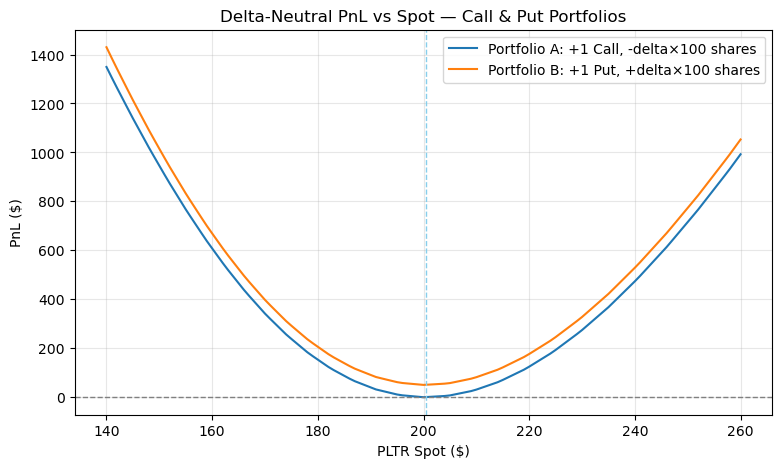

In [12]:
S_grid, pnl_call, pnl_put = delta_neutral_pnl(
    S0, K, r, q, T, iv_call,
    call_mkt, put_mkt, D_call, D_put)

plt.figure(figsize=(9,5))
plt.plot(S_grid, pnl_call, label="Portfolio A: +1 Call, -delta×100 shares")
plt.plot(S_grid, pnl_put,  label="Portfolio B: +1 Put, +delta×100 shares")
plt.axhline(0, color='gray', ls='--', lw=1)
plt.axvline(S0, color='skyblue', ls='--', lw=1)
plt.title("Delta-Neutral PnL vs Spot — Call & Put Portfolios")
plt.xlabel("PLTR Spot ($)")
plt.ylabel("PnL ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()